In [29]:
import torch 
import os
import math
import numpy as np
import ot 
import plotly.express as px
import scipy
from torch_ema import ExponentialMovingAverage
from matplotlib import pyplot as plt
from matplotlib import cm
import tqdm 
from abc import ABC, abstractmethod
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from geomloss import SamplesLoss
from collections import defaultdict
import sklearn
import pandas as pd
import plotly.graph_objects as go


torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Utils

In [3]:
def sample_moons(shape: torch.Size, *, noise_std: float = 0.05) -> torch.Tensor:
    """
    Generate samples from the two moons dataset.

    Args:
        shape (torch.Size): The desired output shape (excluding the last dimension, which will be 2).
        noise_std (float, optional): Standard deviation of Gaussian noise added to the data. Default is 0.05.

    Returns:
        torch.Tensor: Samples from the two moons dataset with shape (*shape, 2).
    """
    n = math.prod(shape)

    x0 = sklearn.datasets.make_moons(n_samples=n, noise=noise_std)[0]
    x0 = torch.as_tensor(x0)
    x0 = x0 - torch.tensor([0.5, 0.25])

    x0 = x0.reshape(*shape, -1)
    return x0 


def sample_eight_gaussians(shape: torch.Size, *, radius: float = 2.0, noise_std: float = 0.2) -> torch.Tensor:
    """
    Generate samples from a mixture of eight 2D Gaussians arranged in a circle.

    Args:
        shape (torch.Size): The desired output shape (excluding the last dimension, which will be 2).
        radius (float, optional): The radius of the circle on which the Gaussian centers are placed. Default is 2.0.
        noise_std (float, optional): Standard deviation of each Gaussian. Default is 0.2.

    Returns:
        torch.Tensor: Samples from the eight Gaussians dataset with shape (*shape, 2).
    """
    n = math.prod(shape)

    angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
    centers = np.column_stack([np.cos(angles), np.sin(angles)]) * radius
    x1 = sklearn.datasets.make_blobs(
        n_samples=n, 
        centers=centers, 
        cluster_std=noise_std, 
    )[0]
    x1 = torch.as_tensor(x1)

    x1 = x1.reshape(*shape, -1)
    return x1


def matmul_many(matrix: torch.Tensor, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
    """
    Applies the given matrix to each tensor in *args using matrix multiplication along the last dimension.

    Args:
        matrix (torch.Tensor): The matrix to multiply with, shape [M, N].
        *args (torch.Tensor): One or more tensors to be multiplied, each with last dimension N.

    Returns:
        torch.Tensor or tuple[torch.Tensor, ...]: The result(s) of the matrix multiplication.
    """
    results = tuple(torch.einsum("ij, ...j -> ...i", matrix, x) for x in args)
    if len(results) == 1:
        return results[0]
    return results


def torch_divmod(n: torch.Tensor, d: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Equivalent to divmod for tensors. TODO If implemented nicely in pytorch, could submit a PR. 

    parameters:
        n: torch.Tensor, shape [...]
        d: int

    returns:
        tuple of tensors, shape [...]
    """
    return n // d, n % d


def joint_multinomial(distribution: torch.Tensor, num_samples: int, replacement: bool = True) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Sample from a joint categorical distribution.

    parameters:
        distribution: torch.Tensor, shape (N, M)
        num_samples: int, number of samples to draw
        replacement: bool, whether to sample with replacement

    returns:
        torch.Tensor, shape (num_samples, 2)
    """
    n, _ = distribution.shape
    res = torch.multinomial(distribution.flatten(), num_samples, replacement=replacement)
    res_i, res_j = torch_divmod(res, n)
    return res_i, res_j


def as_tensors(*args, dtype: torch.dtype | None = None, device: torch.device | None = None) -> tuple[torch.Tensor, ...]:
    """
    Convert all arguments to tensors.
    """
    return tuple(torch.as_tensor(arg, dtype=dtype, device=device) for arg in args)


class Moons(torch.distributions.Distribution):
    """
    A PyTorch Distribution representing the two moons dataset.

    Args:
        noise_std (float, optional): Standard deviation of Gaussian noise added to the data. Default is 0.05.

    Methods:
        sample(shape): Generate samples from the two moons dataset with the specified shape.
    """

    def __init__(self, noise_std: float = 0.05) -> None:
        super().__init__(validate_args=False)
        self.noise_std = noise_std

    def sample(self, shape) -> torch.Tensor: 
        """
        Generate samples from the two moons dataset.

        Args:
            shape: The desired output shape (excluding the last dimension, which will be 2).

        Returns:
            torch.Tensor: Samples from the two moons dataset with shape (*shape, 2).
        """
        return sample_moons(shape, noise_std=self.noise_std)


class EightGaussians(torch.distributions.Distribution):
    """
    A PyTorch Distribution representing a mixture of eight Gaussians arranged in a circle.

    Args:
        radius (float, optional): The radius of the circle on which the Gaussian centers are placed. Default is 2.0.
        noise_std (float, optional): Standard deviation of each Gaussian. Default is 0.2.

    Methods:
        sample(shape): Generate samples from the eight Gaussians dataset with the specified shape.
    """

    def __init__(self, radius: float = 2.0, noise_std: float = 0.2) -> None:
        super().__init__(validate_args=False)
        self.radius = radius 
        self.noise_std = noise_std

    def sample(self, shape) -> torch.Tensor:
        """
        Generate samples from the eight Gaussians dataset.

        Args:
            shape: The desired output shape (excluding the last dimension, which will be 2).

        Returns:
            torch.Tensor: Samples from the eight Gaussians dataset with shape (*shape, 2).
        """
        return sample_eight_gaussians(shape, radius=self.radius, noise_std=self.noise_std)
        

class PossiblyDegenerateNormal(torch.distributions.Normal):
    """
    A Normal distribution that allows for degenerate cases where the scale (standard deviation) is zero.

    This class extends torch.distributions.Normal to handle the case where the scale parameter is zero,
    i.e., the distribution becomes a Dirac delta at the mean (loc). In such cases:
      - log_prob returns 0 if value == loc, -inf otherwise.
      - cdf returns 1 if value >= loc, 0 otherwise.
      - icdf always returns loc.

    Args:
        loc (torch.Tensor | float): Mean of the distribution.
        scale (torch.Tensor | float): Standard deviation (can be zero).
        validate_args (bool | None): Whether to validate input arguments.

    Attributes:
        is_degenerate (bool or torch.Tensor): Indicates if the distribution is degenerate (scale == 0).
    """

    arg_constraints = {
        "loc": torch.distributions.constraints.real, 
        "scale": torch.distributions.constraints.greater_than_eq(0.0),
    }

    # TODO support is still given as Real()

    def __init__(
        self, 
        loc: torch.Tensor | float, 
        scale: torch.Tensor | float, 
        validate_args: bool | None = None, 
    ) -> None:
        super().__init__(loc=loc, scale=scale, validate_args=validate_args)
        self.is_degenerate = scale == 0.0

    def log_prob(self, value: torch.Tensor) -> torch.Tensor:
        """
        Computes the log probability of the given value under the distribution.

        For degenerate cases (scale == 0), returns 0 if value == loc, -inf otherwise.
        """
        log_prob_if_nondegenerate = super().log_prob(value)
        log_prob_if_degenerate = torch.where(
            self.loc == value, # This broadcasts in the same way as super().log_prob
            0.0, 
            -torch.inf,
        )
        return torch.where(
            self.is_degenerate,
            log_prob_if_degenerate, 
            log_prob_if_nondegenerate,
        )

    def cdf(self, value: torch.Tensor) -> torch.Tensor:
        """
        Computes the cumulative distribution function at the given value.

        For degenerate cases (scale == 0), returns 1 if value >= loc, 0 otherwise.
        """
        cdf_if_nondegenerate = super().cdf(value)
        cdf_if_degenerate = torch.where(
            self.loc <= value, 
            1.0,
            0.0,
        )
        return torch.where(
            self.is_degenerate,
            cdf_if_degenerate, 
            cdf_if_nondegenerate,
        ) 

    def icdf(self, value: torch.Tensor) -> torch.Tensor:
        """
        Computes the inverse cumulative distribution function at the given value.

        For degenerate cases (scale == 0), always returns loc.
        """
        icdf_if_nondegenerate = super().icdf(value)
        icdf_if_degenerate = self.loc
        return torch.where(
            self.is_degenerate,
            icdf_if_degenerate, 
            icdf_if_nondegenerate,
        )

## SDEs and SDE solvers

In [4]:
class SDE(ABC):
    """
    Base class for all SDEs. 

    TODO Currently covariance returns the diagonal of the covariance matrix, as in the diagonal case. 
    Ideally, we would have a separate method for this and move the implementation to diagonal SDE. 
    """

    def __init__(self, dim: int):
        self._dim = dim 

    @property
    def dim(self) -> int:
        return self._dim
    
    @abstractmethod
    def drift(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def diffusion(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def transition(
        self, 
        t0: torch.Tensor, 
        t1: torch.Tensor,
    ) -> torch.Tensor:
        pass

    def _mean(self, t: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Unconditional mean not implemented for this SDE.") 

    @abstractmethod
    def _mean_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _mean_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def mean(
        self, 
        t: torch.Tensor, 
        *,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the mean of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Mean.
        """
        if x0 is not None and x1 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            if t1 is None:
                t1 = t.new_ones(t.shape) # [...]
            return self._mean_with_initial_and_final_condition(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        elif x0 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            return self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        else:
            return self._mean(t)

    def _variance(
        self, 
        t: torch.Tensor, 
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional variance not implemented for this SDE.") 

    @abstractmethod
    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def _variance_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None, 
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def variance(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.
        
        returns: 
            torch.Tensor: [..., D] Variance.
        """
        # Set times to default values 
        if t0 is True:
            t0 = t.new_zeros(t.shape) # [...]
        if t1 is True:
            t1 = t.new_ones(t.shape) # [...]

        # Get variance assuming stochastic dimension
        if t0 is not None and t1 is not None:
            res = self._variance_with_initial_and_final_condition(t=t, t0=t0, t1=t1)
        elif t0 is not None:
            res = self._variance_with_initial_condition(t=t, t0=t0)
        else:
            res = self._variance(t)

        return res

    def _covariance(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional covariance not implemented for this SDE.") 

    def _covariance_with_initial_condition(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the covariance of the SDE between times s and t conditioned on being at x0 at time t0. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Conditioning times.
        returns: 
            torch.Tensor: [..., D] Diagonal of the (diagonal) covariance matrix.
        """
        r = torch.minimum(s, t)
        return self.transition(t0=r, t1=t) * self.variance(t=r, t0=t0) * self.transition(t0=r, t1=s)

    def _covariance_with_initial_and_final_condition(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
        *, 
        t0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        # This could be implemented already here by conditioning of Gaussian processes, but is not needed for now. 
        raise NotImplementedError("Unconditional covariance not implemented yet. Can be implemented by the Gaussian process conditioning rule.") 

    def covariance(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        if (t0 is True or t0 is not None) and (t1 is True or t1 is not None):
            return self._covariance_with_initial_and_final_condition(s=s, t=t, t0=t0, t1=t1)
        elif (t0 is True or t0 is not None):
            return self._covariance_with_initial_condition(s=s, t=t, t0=t0)
        else: 
            return self._covariance(s=s, t=t)

    @abstractmethod
    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """


class DiagonalSDE(SDE):

    def _variance_with_initial_and_final_condition(self, t: torch.Tensor, *, t0: torch.Tensor | None = None, t1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero variance at time t0 and t1.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.
            t1 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the conditional variance of the SDE.
        """
        sigmatt_given_t0 = self.variance(t=t, t0=t0)
        sigmat1t_given_t0 = self.covariance(s=t, t=t1, t0=t0)
        sigmat1t1_given_t0 = self.variance(t=t1, t0=t0)
        
        sigmatt_given_t0t1 = sigmatt_given_t0 - sigmat1t_given_t0.square() / sigmat1t1_given_t0

        return sigmatt_given_t0t1

    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """
        if x0 is not None and t0 is None:
            t0 = t.new_zeros(t.shape) # [...]
        if x1 is not None and t1 is None:
            t1 = t.new_ones(t.shape) # [...]

        mean = self.mean(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        variance = self.variance(t=t, t0=t0, t1=t1)
        normal = PossiblyDegenerateNormal(loc=mean, scale=variance.sqrt())
        return torch.distributions.Independent(normal, reinterpreted_batch_ndims=1)


class OUDiagonalSDE(DiagonalSDE):
    def __init__(self, alpha_diagonal: torch.Tensor, gamma_diagonal: torch.Tensor):
        """
        Creates the diagonal OU SDE.

        ..math:: 
            dX_t = \alpha X_t dt + \gamma dW_t

        parameters: 
            alpha_diagonal (torch.Tensor): [D] Vector representing the diagonal of the (diagonal) drift matrix alpha.
            gamma_diagonal (torch.Tensor): [D] Vector representing the diagonal of the (diagonal) diffusion matrix gamma.
        """
        super().__init__(dim=alpha_diagonal.shape[0])
        self.alpha_diagonal = alpha_diagonal
        self.gamma_diagonal = gamma_diagonal

    def drift(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the drift of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Drift of the SDE.
        """
        return self.alpha_diagonal * x

    def diffusion(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the diffusion of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.

        returns: 
            torch.Tensor: [D] Diffusion of the SDE.
        """
        return self.gamma_diagonal

    def transition(self, t0: torch.Tensor, t1: torch.Tensor) -> torch.Tensor:
        """
        Returns a vector representing the transition matrix, which is itself a diagonal matrix. 

        parameters: 
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the transition matrix.
        """
        delta = t1 - t0 # [...]
        return torch.exp(torch.einsum("d, ... -> ...d", self.alpha_diagonal, delta))

    def _variance_with_initial_condition_over_gamma_squared(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        min_alpha_nonzero: float = 1e-8,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero-variance at time t0.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the variance of the SDE.
        """
        variance_if_alpha_zero = (t - t0).unsqueeze(-1) # [..., 1]
        variance_if_alpha_nonzero = (
            (self.transition(t0=t0, t1=t).square() - 1) / (2 * self.alpha_diagonal)
        ) # [..., D]
        return torch.where(self.alpha_diagonal.abs() < min_alpha_nonzero, variance_if_alpha_zero, variance_if_alpha_nonzero) # [..., D]


    def _covariance_with_initial_condition_over_gamma_squared(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        min_alpha_nonzero: float = 1e-8,
    ) -> torch.Tensor:
        """
        Returns the covariance of the SDE between times s and t conditioned on being at x0 at time t0. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Conditioning times.
        returns: 
            torch.Tensor: [..., D] Diagonal of the (diagonal) covariance matrix.
        """
        r = torch.minimum(s, t)
        return (
            self.transition(t0=r, t1=t) 
            * self._variance_with_initial_condition_over_gamma_squared(t=r, t0=t0, min_alpha_nonzero=min_alpha_nonzero) 
            * self.transition(t0=r, t1=s)
        )

    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        min_alpha_nonzero: float = 1e-8
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero-variance at time t0.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the variance of the SDE.
        """
        return self.gamma_diagonal.square() * self._variance_with_initial_condition_over_gamma_squared(t=t, t0=t0, min_alpha_nonzero=min_alpha_nonzero)

    def _mean_with_initial_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0.
        
        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Mean of the SDE.
        """
        return self.transition(t0=t0, t1=t) * x0 # [..., D] * [..., D] -> [..., D]

    def _mean_with_initial_and_final_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None, t1: torch.Tensor | None = None, x1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0 and x1 at time t1. 

        parameters: 
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Conditional mean of the SDE.
        """
        m_t = self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        m_t1 = self._mean_with_initial_condition(t=t1, t0=t0, x0=x0)
        sigma_t1t_over_gamma_squared = self._covariance_with_initial_condition_over_gamma_squared(s=t, t=t1, t0=t0) # FIXME This should be symmetric but is antisymmetric
        sigma_t1t1_over_gamma_squared = self._variance_with_initial_condition_over_gamma_squared(t=t1, t0=t0)
        return m_t + sigma_t1t_over_gamma_squared / sigma_t1t1_over_gamma_squared * (x1 - m_t1)
     

class PossiblyDegenerateOUDiagonalSDE(OUDiagonalSDE):
    """
    Extension of OUDiagonalizableSDE that handles the possibility of degenerate (zero) diffusion coefficients.

    If any entry in gamma_diagonal is zero, the corresponding variance and covariance entries are set to zero,
    effectively treating those dimensions as deterministic.

    Attributes:
        is_degenerate (torch.Tensor): Boolean tensor indicating which dimensions are degenerate (gamma_diagonal == 0).
    """

    def __init__(self, alpha_diagonal: torch.Tensor, gamma_diagonal: torch.Tensor):
        """
        Initializes the PossiblyDegenerateOUDiagonalizableSDE.

        Args:
            alpha_diagonal (torch.Tensor): Diagonal elements of the drift matrix.
            gamma_diagonal (torch.Tensor): Diagonal elements of the diffusion matrix.
        """
        super().__init__(alpha_diagonal, gamma_diagonal)
        self.is_degenerate = self.gamma_diagonal == 0.0

    def variance(self, t: torch.Tensor, *, t0: torch.Tensor | bool | None = None, t1: torch.Tensor | bool | None = None) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, setting variance to zero for degenerate dimensions.

        Args:
            t (torch.Tensor): Times at which to evaluate the variance.
            t0 (torch.Tensor | bool | None, optional): Initial times or condition.
            t1 (torch.Tensor | bool | None, optional): Final times or condition.

        Returns:
            torch.Tensor: Variance tensor with zeros in degenerate dimensions.
        """
        return torch.where(
            self.is_degenerate, 
            0.0, 
            super().variance(t=t, t0=t0, t1=t1),
        )

    def covariance(self, s: torch.Tensor, t: torch.Tensor, *, t0: torch.Tensor | bool | None = None, t1: torch.Tensor | bool | None = None) -> torch.Tensor:
        """
        Returns the covariance of the SDE between times s and t, setting covariance to zero for degenerate dimensions.

        Args:
            s (torch.Tensor): Start times.
            t (torch.Tensor): End times.
            t0 (torch.Tensor | bool | None, optional): Initial times or condition.
            t1 (torch.Tensor | bool | None, optional): Final times or condition.

        Returns:
            torch.Tensor: Covariance tensor with zeros in degenerate dimensions.
        """
        return torch.where(
            self.is_degenerate, 
            0.0, 
            super().covariance(s=s, t=t, t0=t0, t1=t1),
        )


class HeatBMTSDE(PossiblyDegenerateOUDiagonalSDE):
    def __init__(
        self, 
        eigenvalues: torch.Tensor, 
        c: float, 
        sigma: torch.Tensor, 
    ) -> None:
        """
        Creates the heat BM SDE:

        ..math:: 
            dX_t = -cLX_t dt + \sigma dW_t

        parameters: 
            L (torch.Tensor): [D, D] Matrix representing the Laplacian.
            c (torch.Tensor): [] Scalar greater than or equal to 0.
            sigma (torch.Tensor): [] Scalar diffusion coefficient.
        """
        c = eigenvalues.new_tensor(c)
        sigma = eigenvalues.new_tensor(sigma)
        
        alpha_diagonal = -c * eigenvalues
        gamma_diagonal = sigma * torch.ones_like(eigenvalues)
        
        super().__init__(alpha_diagonal=alpha_diagonal, gamma_diagonal=gamma_diagonal)


class Frame:
    def transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        """
        Transforms input tensors into the coordinate frame defined by U.

        Args:
            *args (torch.Tensor): One or more tensors to transform. Each tensor should have its last dimension compatible with U.

        Returns:
            torch.Tensor or tuple[torch.Tensor, ...]: Transformed tensor(s) in the new coordinate frame.
        """

    def inverse_transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        """
        Inverse transforms input tensors from the coordinate frame defined by U back to the original frame.

        Args:
            *args (torch.Tensor): One or more tensors to inverse transform. Each tensor should have its last dimension compatible with U.

        Returns:
            torch.Tensor or tuple[torch.Tensor, ...]: Inverse transformed tensor(s) in the original coordinate frame.
        """

class SpectralFrame(Frame):

    def __init__(self, L: torch.Tensor) -> None:
        super().__init__()
        self.D, self.U = torch.linalg.eigh(L)


    def transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        """
        Transforms input tensors into the coordinate frame defined by U.

        Args:
            *args (torch.Tensor): One or more tensors to transform. Each tensor should have its last dimension compatible with U.

        Returns:
            torch.Tensor or tuple[torch.Tensor, ...]: Transformed tensor(s) in the new coordinate frame.
        """
        return matmul_many(self.U.mT, *args)

    def inverse_transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        """
        Inverse transforms input tensors from the coordinate frame defined by U back to the original frame.

        Args:
            *args (torch.Tensor): One or more tensors to inverse transform. Each tensor should have its last dimension compatible with U.

        Returns:
            torch.Tensor or tuple[torch.Tensor, ...]: Inverse transformed tensor(s) in the original coordinate frame.
        """
        return matmul_many(self.U, *args)

    @property
    def eigenvalues(self) -> torch.Tensor:
        """
        Returns the eigenvalues of the Laplacian matrix used to define the spectral frame.
        """
        return self.D


class StandardFrame(Frame):

    def transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        return args[0] if len(args) == 1 else args

    def inverse_transform(self, *args: torch.Tensor) -> torch.Tensor | tuple[torch.Tensor, ...]:
        return args[0] if len(args) == 1 else args


class TimeSteps:
    # TODO For a more advanced SDE solver, this might need to be an iterator

    def __init__(self, t: torch.Tensor, dt: torch.Tensor) -> None:
        assert t.dtype == dt.dtype, "t and dt should have the same dtype"
        assert t.device == dt.device, "t and dt should be on the same device"
        self._t = t
        self._dt = dt

    @property
    def t(self) -> torch.Tensor:
        return self._t

    @property
    def dt(self) -> torch.Tensor:
        return self._dt

    @property
    def device(self) -> torch.device:
        return self.t.device

    @property
    def dtype(self) -> torch.dtype:
        return self.t.dtype


class UniformTimeSteps(TimeSteps):
    """
    UniformTimesteps generates a sequence of uniformly spaced timesteps between 0 and 1 (inclusive),
    with an optional initial value t0 for the first timestep. It also provides the uniform delta t
    between steps. 

    Attributes:
        n (int): Number of intervals (number of timesteps is n+1).
        t (torch.Tensor): 1D tensor of shape (n+1,) containing the timesteps.
        dt (torch.Tensor): 1D tensor of shape (n,) containing the uniform time differences between steps.
        device (torch.device or None): The device on which the tensors are stored.

    Methods:
        to(device): Moves the tensors to the specified device.
    """
    def __init__(self, n: int, *, t0: float = 1e-4, device: torch.device | None = None, dtype: torch.dtype | None = None):
        """
        Initializes the UniformTimesteps object.

        Args:
            n (int): Number of intervals (must be greater than 0).
            device (torch.device, optional): Device to store the tensors on.
            dtype (torch.dtype, optional): Data type of the tensors.
            t0 (float, optional): Initial value for the first timestep. If None, defaults to 1e-4.
        """
        assert n > 0, "Number of timesteps must be greater than 0"

        t = torch.linspace(0, 1, n + 1, dtype=dtype, device=device)
        t[0] = t0
        
        dt = torch.full((n, ), 1.0 / n, dtype=dtype, device=device)

        super().__init__(t=t, dt=dt)

## Controls

In [5]:
def _bridge_control_generic(
    sde: SDE, 
    t: torch.Tensor, 
    x: torch.Tensor, 
    *, 
    t1: torch.Tensor | None = None, 
    x1: torch.Tensor,
) -> torch.Tensor:
    """
    Returns the control for the bridge of the SDE at time t and position x needed to reach x1 at time t1. 

    parameters: 
        sde (SDE): The SDE to create the bridge control for.
        t (torch.Tensor): [...] Current times.
        x (torch.Tensor): [..., D] Current values.
        t1 (torch.Tensor): [...] Target times.
        x1 (torch.Tensor): [..., D] Target values.

    returns: 
        torch.Tensor: [..., D] Control.
    """
    if t1 is None:
        t1 = x1.new_ones(x1.shape[:-1]) # [...]
    score = sde.transition(t0=t, t1=t1) * (x1 - sde.mean(t0=t, x0=x, t=t1)) / sde.variance(t0=t, t=t1)
    return sde.diffusion(t=t).square() * score


def _bridge_control_ou(
    sde: OUDiagonalSDE, 
    t: torch.Tensor, 
    x: torch.Tensor, 
    *, 
    t1: torch.Tensor | None = None, 
    x1: torch.Tensor,
) -> torch.Tensor:
    """
    Returns the control for the bridge of the Ornstein-Uhlenbeck (OU) SDE at time t and position x,
    needed to reach x1 at time t1. Works in the ODE case (zero-noise) as well.

    Parameters:
        sde (OUDiagonalizableSDE): The OU SDE to create the bridge control for.
        t (torch.Tensor): Current times. Shape: [...]
        x (torch.Tensor): Current values. Shape: [..., D]
        t1 (torch.Tensor, optional): Target times. Shape: [...]. If None, should be provided by caller.
        x1 (torch.Tensor): Target values. Shape: [..., D]

    Returns:
        torch.Tensor: The control tensor of shape [..., D].
    """
    return (
        sde.transition(t0=t, t1=t1) 
        * (x1 - sde.mean(t0=t, x0=x, t=t1)) 
        / sde._variance_with_initial_condition_over_gamma_squared(t0=t, t=t1)
    )


def bridge_control(
    sde: SDE, 
    t: torch.Tensor, 
    x: torch.Tensor, 
    *, 
    t1: torch.Tensor | None = None, 
    x1: torch.Tensor,
) -> torch.Tensor:
    """
    Returns the control for the bridge of the SDE at time t and position x needed to reach x1 at time t1. 

    parameters: 
        sde (SDE): The SDE to create the bridge control for.
        t (torch.Tensor): [...] Current times.
        x (torch.Tensor): [..., D] Current values.
        t1 (torch.Tensor): [...] Target times.
        x1 (torch.Tensor): [..., D] Target values.

    returns: 
        torch.Tensor: [..., D] Control.
    """
    if t1 is None:
        t1 = x1.new_ones(x1.shape[:-1]) # [...]

    if isinstance(sde, OUDiagonalSDE):
        return _bridge_control_ou(sde=sde, t=t, x=x, t1=t1, x1=x1)
    else:
        return _bridge_control_generic(sde=sde, t=t, x=x, t1=t1, x1=x1)


class Control:
    """
    Abstract base class for control policies in SDEs.

    This class defines the interface for control policies, which compute a control signal
    at a given time and state. Subclasses should implement the `control` method.
    """

    @abstractmethod
    def control(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Computes the control at time t and position x.

        Parameters:
            t (torch.Tensor): Current times. Shape: [...]
            x (torch.Tensor): Current values. Shape: [..., D]
            **kwargs: Additional keyword arguments.

        Returns:
            torch.Tensor: The control tensor of shape [..., D].
        """
        pass 

    def __call__(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the control at time t and position x. 

        Parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        Returns: 
            torch.Tensor: [..., D] Control.
        """
        return self.control(t=t, x=x, **kwargs)


class ZeroControl(Control):
    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x.new_zeros(x.shape) # [..., D]


class BridgeControl(Control):
    def __init__(self, sde: SDE, x1: torch.Tensor, t1: torch.Tensor | None = None): 
        """
        Creates the bridge control for the SDE conditioned on being at x1 at time t1. 

        parameters: 
            sde (SDE): The SDE to create the bridge control for.
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.
        """
        super().__init__()
        self.sde = sde
        self._x1 = None
        self._t1 = None
        self.condition(x1=x1, t1=t1)

    def condition(self, x1: torch.Tensor, t1: torch.Tensor | None = None) -> "BridgeControl":
        """
        Conditions the bridge on being at x1 at time t1. 

        parameters: 
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            BridgeControl: The bridge control.
        """
        if t1 is None:
            t1 = x1.new_ones(x1.shape[:-1]) # [...]
        self._x1 = x1
        self._t1 = t1
        return self

    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the control for the bridge at time t and position x. 

        parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        returns: 
            torch.Tensor: [..., D] Control.
        """
        return bridge_control(sde=self.sde, t=t, x=x, t1=self._t1, x1=self._x1)


class ModelControl(Control):
    """
    Control class that wraps a PyTorch model to provide control for SDEs.

    Parameters:
        model (torch.nn.Module): The neural network model to use for control.
        device (torch.device | None): The device to run the model on.
    """
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model 

    def __call__(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Calls the underlying model with time and state.

        Parameters:
            t (torch.Tensor): Time tensor.
            x (torch.Tensor): State tensor.

        Returns:
            torch.Tensor: Output of the model.
        """
        return self.model(t, x)


## SDE solvers

In [6]:
class SDESolver(ABC):
    def __init__(self, sde: SDE) -> None:
        self.sde = sde 

    @abstractmethod
    def pushforward(self, x0: torch.Tensor, *, control: Control | None = None) -> torch.Tensor:
        """
        Push x0 along the SDE to time 1.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Terminal value.
        """

    @abstractmethod
    def sample_path(self, x0: torch.Tensor, *, control: Control | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples a path from the SDE.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            tuple[torch.Tensor, torch.Tensor]: [..., T, D] Path and [T] Time.
        """


class EulerMaruyamaSolver(SDESolver):
    def __init__(self, sde: SDE, *, time_steps: TimeSteps):
        # TODO Maybe move the SDE into sample_path.
        super().__init__(sde=sde)
        self.time_steps = time_steps

    def dx(self, dt: torch.Tensor, t: torch.Tensor, x: torch.Tensor, *, control: Control) -> torch.Tensor:
        """
        Returns the change in the SDE. 

        parameters: 
            dt (torch.Tensor): [] Duration of the timestep.
            t (torch.Tensor): [] Time.
            x (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Change in the SDE.
        """
        t = t.expand(x.shape[:-1])
        drift = self.sde.drift(t=t, x=x) + control(t=t, x=x)
        diffusion = self.sde.diffusion(t=t, x=x)
        return drift * dt + diffusion * torch.sqrt(dt) * torch.randn_like(x)

    def pushforward(self, x0: torch.Tensor, *, control: Control | None = None) -> torch.Tensor:
        """
        Push x0 along the SDE to time 1.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Terminal value.
        """
        if control is None: control = ZeroControl()

        ts = self.time_steps.t
        dts = self.time_steps.dt

        x = x0
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt=dt, t=t, x=x, control=control)

        return x 

    def sample_path(self, x0: torch.Tensor, *, control: Control | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples a path from the SDE.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            tuple[torch.Tensor, torch.Tensor]: [..., T, D] Path and [T] Time.
        """
        # normal sample 
        if control is None: control = ZeroControl()

        ts = self.time_steps.t
        dts = self.time_steps.dt

        x = x0
        xs = [x]
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt=dt, t=t, x=x, control=control)
            xs.append(x)
        xs = torch.stack(xs, dim=-2)        

        return xs, ts

## Optimal Transport

In [155]:
class OTSolver: 
    """
    Optimal Transport Solver for SDEs.

    This class computes the optimal transport plan between two distributions
    using the cost induced by a given SDE. It supports optional normalization
    of the variance and regularization via epsilon. Also supports ODEs. 

    Args:
        sde (SDE): The stochastic differential equation object providing mean and variance.
        normalize_variance (bool, optional): Whether to normalize the variance for numerical stability. Default is True.

    Attributes:
        sde (SDE): The SDE object.
        possibly_scaled_std (torch.Tensor): The (possibly normalized) standard deviation tensor.
    """

    def __init__(self, sde: SDE, *, normalize_variance: bool = False):
        self.sde = sde
        
        variance_1_given_0 = sde.variance(t=torch.tensor(1.0), t0=torch.tensor(0.0))

        variance_1_given_0_is_degenerate = variance_1_given_0 == 0.0

        if normalize_variance is False:
            epsilon = 0.0
            possibly_scaled_variance_nondegenerate = variance_1_given_0
        else:
            epsilon = torch.prod(
                variance_1_given_0[~variance_1_given_0_is_degenerate]
            ).pow(1 / sde.dim).detach().cpu().item()
            possibly_scaled_variance_nondegenerate = variance_1_given_0 / epsilon
        
        self.possibly_scaled_std: torch.Tensor = torch.where(
            variance_1_given_0_is_degenerate, 
            1.0, 
            possibly_scaled_variance_nondegenerate,
        ).sqrt()
        self.epsilon: float = epsilon

    def cost(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost matrix between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [..., N, D] Initial value.
            x1 (torch.Tensor): [..., M, D] Target value.

        returns: 
            torch.Tensor: [..., N, M] Cost matrix.
        """
        assert x0.ndim >= 2, "x0 must have at least 2 dimensions"
        assert x1.ndim >= 2, "x1 must have at least 2 dimensions"

        # Expand x0 and x1 for broadcasting
        # x0_expanded: [..., N, 1, D]
        # x1_expanded: [..., 1, M, D]
        x0_expanded = x0.unsqueeze(-2)  # [..., N, 1, D]
        x1_expanded = x1.unsqueeze(-3)  # [..., 1, M, D]

        # Compute cost for each pair (n, m)
        # Use the same cost as in self.cost, but vectorized
        t0 = x0.new_zeros(x0.shape[:-2] + (x0.shape[-2], 1))  # [..., N, 1]
        t1 = x1.new_ones(x0.shape[:-2] + (1, x1.shape[-2]))   # [..., 1, M]
        # mean: [..., N, 1, D]
        mean = self.sde.mean(t0=t0, x0=x0_expanded, t=t1)
        # normed_variance: [D]
        z = (x1_expanded - mean) / self.possibly_scaled_std  # ([..., 1, M, D] - [..., N, 1, D]) / [D] -> [..., N, M, D]
        cost = torch.linalg.vector_norm(z, ord=2, dim=-1)  # [..., N, M]
        return cost

    def solve(
        self, 
        x0: torch.Tensor, 
        x1: torch.Tensor, 
        method: str = "sinkhorn",
        num_iter_max: int = 1000,
        stop_threshold: float = 1e-9,
        verbose: bool = False,
        log: bool = False,
        warn: bool = True,
    ) -> torch.Tensor:
        """
        Returns the optimal transport plan between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [..., N, D] Initial value.
            x1 (torch.Tensor): [..., M, D] Target value.

        returns: 
            torch.Tensor: [..., N, M] Optimal transport plan.
        """
        assert x0.ndim >= 2, "x0 must have 2 dimensions"
        assert x1.ndim >= 2, "x1 must have 2 dimensions"

        cost_matrix = self.cost(x0, x1)
        px0 = x0.new_ones(x0.shape[0]) / x0.shape[0]
        px1 = x1.new_ones(x1.shape[0]) / x1.shape[0]

        # convert to numpy
        cost_matrix = cost_matrix.detach().cpu().numpy()
        px0 = px0.detach().cpu().numpy()
        px1 = px1.detach().cpu().numpy()
        epsilon = self.epsilon

        # TODO Maybe extract into separate private methods
        if epsilon == 0.0:
            optimal_plan = ot.emd(
                a=px0, 
                b=px1, 
                M=cost_matrix, 
                log=log,
            )
        else:
            optimal_plan = ot.sinkhorn(
                a=px0, 
                b=px1, 
                M=cost_matrix, 
                reg=epsilon, 
                method=method,
                num_iter_max=num_iter_max, 
                stop_threshold=stop_threshold, 
                verbose=verbose, 
                log=log, 
                warn=warn
            )

        return torch.as_tensor(optimal_plan, device=x0.device, dtype=x0.dtype)

    @property
    def is_exact(self) -> bool:
        """
        Returns True if the optimal transport is computed exactly (i.e., epsilon == 0.0),
        otherwise returns False (entropic regularization is used).
        """
        return self.epsilon == 0.0

## Data utils

In [156]:
class TimeSampler(ABC):
    """
    Abstract class for time samplers.
    """

    def __init__(self, device: torch.device | None = None, dtype: torch.dtype | None = None):
        self.device = device
        self.dtype = dtype

    @abstractmethod
    def sample(self, shape: torch.Size) -> torch.Tensor:
        pass


class UniformTimeSampler(TimeSampler):
    def sample(self, shape: torch.Size) -> torch.Tensor:
        return torch.rand(shape, device=self.device, dtype=self.dtype)


class DiscreteTimeSampler(TimeSampler):
    def __init__(self, time_steps: TimeSteps):
        device = time_steps.device 
        dtype = time_steps.dtype 
        super().__init__(device, dtype)
        self.time_steps = time_steps

    def sample(self, shape: torch.Size) -> torch.Tensor:
        # Exclude the last time step
        indices = torch.randint(0, self.time_steps.t.shape[-1] - 1, shape, device=self.device)
        return self.time_steps.t[indices]


class MatchingDataset(torch.utils.data.Dataset):
    def __init__(self, *, frame: Frame | None = None) -> None:
        super().__init__()
        self.frame = frame if frame is not None else StandardFrame() 

    def sample(self, shape: torch.Size) -> tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError("`sample` is undefined for this dataset.")


class MatchingTensorDataset(MatchingDataset):
    def __init__(self, x0: torch.Tensor, x1: torch.Tensor, *, frame: Frame | None = None) -> None:
        super().__init__(frame=frame)
        self.x0, self.x1 = frame.transform(x0, x1)

    def sample(self, shape: torch.Size) -> tuple[torch.Tensor, torch.Tensor]:
        assert len(shape) <= 1, "Shape should be flat."
        idx_x0 = torch.randint(0, self.x0.shape[-2] - 1, shape)
        idx_x1 = torch.randint(0, self.x1.shape[-2] - 1, shape)
        return self.x0[idx_x0], self.x1[idx_x1]


class MatchingDistributionDataset(MatchingDataset):
    def __init__(
        self, 
        x0_distribution: torch.distributions.Distribution, 
        x1_distribution: torch.distributions.Distribution, 
        *, 
        frame: Frame | None = None,
    ) -> None:
        super().__init__(frame=frame)
        self.x0_distribution = x0_distribution
        self.x1_distribution = x1_distribution

    def sample(self, shape: torch.Size) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples x0 and x1 from their respective distributions with the given shape.

        Args:
            shape (torch.Size): The shape of the samples to draw.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Samples from x0_distribution and x1_distribution.
        """
        x0 = self.x0_distribution.sample(shape)
        x1 = self.x1_distribution.sample(shape)
        x0, x1 = self.frame.transform(x0, x1)
        return x0, x1
        

class OTBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: MatchingDataset, ot_solver: OTSolver, batch_size: int, num_batches: int, *, batchwise_ot: bool = False):
        super().__init__()
        self.dataset = dataset
        self.batchwise_ot = batchwise_ot
        self.ot_solver = ot_solver 
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.ot_plan = None

        # Have to do batchwise OT computation, since new batch is sampled at every iteration
        if isinstance(dataset, MatchingDistributionDataset):
            self.batchwise_ot = True

    def _get_ot_plan(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        if self.batchwise_ot is True or self.ot_plan is None: 
            ot_plan = self.ot_solver.solve(x0, x1)
        else:
            ot_plan = self.ot_plan
        return ot_plan 

    def _resample_from_ot_plan(self, x0: torch.Tensor, x1: torch.Tensor):
        x0_idx, x1_idx = joint_multinomial(
            self._get_ot_plan(x0, x1), 
            num_samples=self.batch_size
        )
        return x0[x0_idx], x1[x1_idx]

    def _sample_batch(self):
        if self.batchwise_ot is False: # Were are in the MatchingTensorDataset case 
            x0, x1 = self.dataset.x0, self.dataset.x1
        else:
            x0, x1 = self.dataset.sample((self.batch_size,))
        return self._resample_from_ot_plan(x0, x1)

    def __iter__(self):
        for _ in range(len(self)):
            yield self._sample_batch()

    def __len__(self) -> int:
        return self.num_batches


class MatchingDataLoader:
    def __init__(self, dataset: MatchingDataset, batch_sampler: OTBatchSampler):
        # TODO Maybe move some arguments from batch_sampler to MatchingDataLoader; however, that would slightly go against the DataLoader interface
        self.dataset = dataset
        self.batch_sampler = batch_sampler

    def __iter__(self):
        yield from self.batch_sampler

    def __len__(self) -> int:
        return self.batch_sampler.batch_size * self.batch_sampler.num_batches

    @property
    def batch_size(self) -> int:
        return self.batch_sampler.batch_size

    @property 
    def num_batches(self) -> int:
        return len(self) // self.batch_size

## Datasets

In [157]:
def download_brain_regions_centroids(data_dir: str = './datasets/brain_signals/'):
    csv_url = "https://bitbucket.org/dpat/tools/raw/master/REF/ATLASES/HCP-MMP1_UniqueRegionList.csv"
    brain_regions_centroids_df = pd.read_csv(
        csv_url, 
        usecols=["x-cog", "y-cog", "z-cog"],
        dtype={"x-cog": float, "y-cog": float, "z-cog": float},
    ).rename(columns={"x-cog": "x", "y-cog": "y", "z-cog": "z"})
    brain_regions_centroids_df.to_csv(os.path.join(data_dir, "brain_regions_centroids.csv"), index=False)


def load_brain_regions_centroids(data_dir: str = './datasets/brain_signals/'):
    return pd.read_csv(os.path.join(data_dir, "brain_regions_centroids.csv"))


def plot_brain_signal_3d(signal: torch.Tensor | None = None, width: int = 500, height: int = 500, marker_size: int = 5):
    df = load_brain_regions_centroids()
    if signal is not None:
        df = df.assign(signal=signal.detach().cpu().numpy())
        fig = px.scatter_3d(df, x='x', y='y', z='z', color='signal')
    else:
        fig = px.scatter_3d(df, x='x', y='y', z='z')
    fig.update_traces(marker_size=marker_size)
    fig.update_layout(width=width, height=height)
    fig.show()
    return fig 


def plot_brain_signal_2d(signal: torch.Tensor | None = None, width: int = 400, height: int = 400, marker_size: int = 6):
    df = load_brain_regions_centroids()
    if signal is not None:
        df = df.assign(signal=signal.detach().cpu().numpy())
        fig = px.scatter(df, x='x', y='y', color='signal')
    else:
        fig = px.scatter(df, x='x', y='y')
    fig.update_traces(marker_size=marker_size)
    fig.update_layout(width=width, height=height)
    fig.show()
    return fig 


def load_brain_data() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Loads the brain data from the .mat files and splits it into training and test sets.
    Returns:
        x0: [N, D] Training samples from the aligned dataset.
        x1: [N, D] Training samples from the liberal dataset.
        x0_train: [N_train, D] Training samples from the aligned dataset.
        x0_test: [N_test, D] Test samples from the aligned dataset.
        x1_train: [N_train, D] Training samples from the liberal dataset.
        x1_test: [N_test, D] Test samples from the liberal dataset.
    """
    laplacian = scipy.io.loadmat('./datasets/brain_signals/lap.mat')['L']

    x1 = scipy.io.loadmat('./datasets/brain_signals/aligned.mat')['Xa'].T
    x0 = scipy.io.loadmat('./datasets/brain_signals/liberal.mat')['Xl'].T

    # Split data into training and test sets
    num_train = int(0.8 * x0.shape[0])
    num_test = x0.shape[0] - num_train
    x = np.arange(x0.shape[0])
    random_perm = np.random.permutation(x)
    train_ids, test_ids = random_perm[:num_train], random_perm[num_train:]
    x0_train, x0_test = x0[train_ids], x0[test_ids]
    x1_train, x1_test = x1[train_ids], x1[test_ids]
    return laplacian, x0, x1, x0_train, x0_test, x1_train, x1_test

## Models

In [158]:
def timestep_embedding(
    timesteps: torch.Tensor,
    dim: int,
    max_period: int = 10000
) -> torch.Tensor:
    """
    Create sinusoidal timestep embeddings.

    parameters: 
        timesteps: [...]
        dim: int
        max_period: int

    returns:
        embedding: [..., dim]
    """
    dim_over_2, dim_mod_2 = divmod(dim, 2)
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, dim_over_2, device=timesteps.device, dtype=timesteps.dtype) 
        / dim_over_2
    ) # [D/2]
    args = timesteps.unsqueeze(-1) * freqs.unsqueeze(0) # [..., 1] * [1, D/2] = [..., D/2]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1) # [..., D]

    if dim_mod_2 == 1:
        zero_column = embedding.new_zeros(embedding.shape[0], 1)
        embedding = torch.cat([embedding, zero_column], dim=-1)
    return embedding


class FCs(torch.nn.Module):
    """
    Fully connected feedforward neural network with configurable number of layers.
    """
    def __init__(
        self,
        dim_in: int,
        dim_hid: int,
        dim_out: int,
        num_layers: int = 2
    ) -> None:
        """
        Fully connected feedforward neural network with configurable number of layers.

        Args:
            dim_in (int): Input feature dimension.
            dim_hid (int): Hidden layer dimension.
            dim_out (int): Output feature dimension.
            num_layers (int, optional): Total number of layers (including input and output layers). Default is 2.
        """
        super(FCs, self).__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module('fc_in', torch.nn.Linear(dim_in, dim_hid))
        self.model.add_module('relu_in', torch.nn.ReLU())
        for i in range(num_layers - 2):
            self.model.add_module(f'fc_{i}', torch.nn.Linear(dim_hid, dim_hid))
            self.model.add_module(f'relu_{i}', torch.nn.ReLU())
        self.model.add_module('fc_out', torch.nn.Linear(dim_hid, dim_out))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class ResNet_FC(torch.nn.Module):
    """
    A fully connected network with an initial linear layer followed by a sequence of residual blocks.
    Each residual block consists of several linear layers with SiLU activations.
    """

    def __init__(self, data_dim: int, hidden_dim: int, num_res_blocks: int) -> None:
        """
        Initialize the ResNet_FC module.

        Args:
            data_dim (int): Input feature dimension.
            hidden_dim (int): Hidden layer dimension for all residual blocks.
            num_res_blocks (int): Number of residual blocks.
        """
        super().__init__()
        self.hidden_dim: int = hidden_dim
        self.map: torch.nn.Linear = torch.nn.Linear(data_dim, hidden_dim)
        self.res_blocks: torch.nn.ModuleList = torch.nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)]
        )

    def build_res_block(self) -> torch.nn.Sequential:
        """
        Build a residual block consisting of several linear layers and SiLU activations.

        Returns:
            torch.nn.Sequential: Sequential container of layers forming a residual block.
        """
        hid: int = self.hidden_dim
        layers: list[torch.nn.Module] = []
        widths: list[int] = [hid] * 4
        for i in range(len(widths) - 1):
            layers.append(torch.nn.Linear(widths[i], widths[i + 1]))
            layers.append(torch.nn.SiLU())
        return torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, data_dim).

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        h = self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h

class TimestepBlock(torch.nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(torch.nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class SparseGCNLayer(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        conv_order: int,
        laplacian: torch.Tensor,
        *, 
        aggr_norm: bool = False,
        initialization: str = "xavier_uniform",
    ) -> None:
        assert initialization in ["xavier_uniform", "xavier_normal"]

        super().__init__()        

        self.K = conv_order # K in pytorch geometric
        self.L = laplacian
        self.aggr_norm = aggr_norm

        self.W = torch.nn.Parameter(
            torch.empty(in_channels, out_channels, self.K + 1)
        )
        torch.nn.init.xavier_uniform_(self.W, gain=math.sqrt(2)) # Maybe add option xavier_normal_

        # precompute normalization inverse 
        self.deg_inv = torch.sparse.sum(self.L, dim=1).to_dense().reciprocal_()
        self.deg_inv[~torch.isfinite(self.deg_inv)] = 0.0


    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize the aggregation by the neighborhood size.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Normalized tensor.
        """
        x = torch.einsum("i,ij->ij ", self.deg_inv, x)
        x[~torch.isfinite(x)] = 0.0
        return x

    """
    TODO 
    """


class GCNLayer(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) Layer with Chebyshev polynomial support.

    Args:
        in_channels (int): Number of input channels/features.
        out_channels (int): Number of output channels/features.
        conv_order (int): Order of the Chebyshev polynomial (number of hops).
        laplacian (torch.Tensor): Laplacian or adjacency matrix.
        aggr_norm (bool, optional): Whether to normalize aggregation. Default is False.
        update_func (str or None, optional): Activation function to use after aggregation.
            Options: "sigmoid", "relu", "id", or None. Default is None.
        initialization (str, optional): Weight initialization method.
            Options: "xavier_uniform", "xavier_normal". Default is "xavier_uniform".
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        conv_order: int,
        laplacian: torch.Tensor,
        *, 
        aggr_norm: bool = False,
        update_func: str | None = None,
        initialization: str = "xavier_uniform",
    ) -> None:
        super().__init__()

        self.in_channels: int = in_channels
        self.out_channels: int = out_channels
        self.conv_order: int = conv_order
        self.laplacian: torch.Tensor = laplacian
        self.aggr_norm: bool = aggr_norm
        self.update_func: str | None = update_func
        self.initialization: str = initialization
        assert initialization in ["xavier_uniform", "xavier_normal"]

        self.weight: torch.nn.Parameter = torch.nn.Parameter(
            torch.Tensor(
                self.in_channels,
                self.out_channels,
                1 + self.conv_order,
            )
        )

        self.reset_parameters()

    def reset_parameters(self, gain: float = 1.414) -> None:
        """
        Reset the parameters of the layer using the specified initialization.

        Args:
            gain (float, optional): Gain value for initialization. Default is 1.414.
        """
        if self.initialization == "xavier_uniform":
            torch.nn.init.xavier_uniform_(self.weight, gain=gain)
        elif self.initialization == "xavier_normal":
            torch.nn.init.xavier_normal_(self.weight, gain=gain)

    def aggr_norm_func(self, conv_operator: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize the aggregation by the neighborhood size.

        Args:
            conv_operator (torch.Tensor): The convolution operator (adjacency or Laplacian matrix).
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Normalized tensor.
        """
        neighborhood_size = torch.sum(conv_operator.to_dense(), dim=1)
        neighborhood_size_inv = 1 / neighborhood_size
        neighborhood_size_inv[~(torch.isfinite(neighborhood_size_inv))] = 0

        x = torch.einsum("i,ij->ij ", neighborhood_size_inv, x)
        x[~torch.isfinite(x)] = 0
        return x

    def update(self, x: torch.Tensor) -> torch.Tensor | None:
        """
        Apply the update (activation) function to the input.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor or None: Activated tensor or None if update_func is not recognized.
        """
        if self.update_func == "sigmoid":
            return torch.sigmoid(x)
        if self.update_func == "relu":
            return torch.nn.functional.relu(x)
        if self.update_func == "id":
            return x
        return None

    def chebyshev_conv(
        self,
        conv_operator: torch.Tensor,
        conv_order: int,
        x: torch.Tensor
    ) -> torch.Tensor:
        """
        Perform Chebyshev polynomial convolution.

        Args:
            conv_operator (torch.Tensor): The convolution operator (adjacency or Laplacian matrix).
            conv_order (int): Order of the Chebyshev polynomial.
            x (torch.Tensor): Input tensor of shape (num_simplices, num_channels).

        Returns:
            torch.Tensor: Tensor of shape (num_simplices, num_channels, conv_order).
        """
        num_simplices, num_channels = x.shape
        X = torch.empty(size=(num_simplices, num_channels, conv_order))
        X[:, :, 0] = torch.mm(conv_operator, x)
        for k in range(1, conv_order):
            X[:, :, k] = torch.mm(conv_operator, X[:, :, k - 1])
            if self.aggr_norm:
                X[:, :, k] = self.aggr_norm_func(conv_operator, X[:, :, k])

        return X

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCN layer.

        Args:
            x (torch.Tensor): Input tensor of shape (num_simplices, in_channels).

        Returns:
            torch.Tensor: Output tensor of shape (num_simplices, out_channels).
        """
        num_simplices, _ = x.shape
        x_identity = torch.unsqueeze(x, 2)

        if self.conv_order > 0:
            x = self.chebyshev_conv(self.laplacian, self.conv_order, x)
            x = torch.cat((x_identity, x), 2)

        y = torch.einsum("nik,iok->no", x, self.weight)

        return y # Maybe have relu and sigmoid as update function options


class GCNBlock(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) module composed of multiple GCNLayer layers.

    Args:
        in_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden units in each hidden GCN layer.
        laplacian (torch.Tensor): Laplacian matrix or convolution operator.
        conv_order (int, optional): Order of the Chebyshev polynomial convolution. Default is 1.
        aggr_norm (bool, optional): Whether to apply aggregation normalization. Default is False.
        update_func (Optional[str], optional): Update function to use in GCNLayer ('relu', 'id', etc.). Default is None.
        n_layers (int, optional): Number of GCN layers. Default is 2.
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        laplacian: torch.Tensor,
        *,
        conv_order: int = 1,
        aggr_norm: bool = False,
        update_func: str = None,
        n_layers: int = 2,
    ) -> None:
        super().__init__()
        self.layers: torch.nn.ModuleList = torch.nn.ModuleList(
            [   
                GCNLayer(
                    in_channels=in_channels,
                    out_channels=hidden_channels,
                    conv_order=conv_order, 
                    laplacian=laplacian,
                )
            ]
        )

        for i in range(n_layers - 1):
            if i == n_layers - 2: 
                out_channels = 1
                layer_update_func = 'id'
            else: 
                out_channels = hidden_channels
                layer_update_func = 'relu'
            self.layers.append(
                GCNLayer(
                    in_channels=hidden_channels,
                    out_channels=out_channels,
                    conv_order=conv_order,
                    laplacian=laplacian,
                    aggr_norm=aggr_norm,
                    update_func=layer_update_func,
                )
            )
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the GCN.

        Args:
            x (torch.Tensor): Input tensor of shape (num_nodes, in_channels).

        Returns:
            torch.Tensor: Output tensor after passing through all GCN layers.
        """
        for layer in self.layers:
            x = layer(x)
        return x


class GCN(torch.nn.Module):
    """
    Network using a combination of GCN and ResNet_FC modules with time embedding.

    Args:
        laplacian (torch.Tensor): Laplacian matrix of the graph (shape: [N, N]).
        hidden_dim (int, optional): Number of hidden units in each layer. Default is 256.
        time_embed_dim (int, optional): Dimensionality of the time embedding. Default is 128.
    """
    def __init__(
        self,
        laplacian: torch.Tensor,
        hidden_dim: int = 256,
        time_embed_dim: int = 128
    ) -> None:
        super().__init__()
        data_dim: int = laplacian.shape[-1]

        self.time_embed_dim: int = time_embed_dim
        hid: int = hidden_dim

        self.t_module: torch.nn.Sequential = torch.nn.Sequential(
            torch.nn.Linear(self.time_embed_dim, hid),
            torch.nn.SiLU(),
            torch.nn.Linear(hid, hid),
        )

        self.x_module1: GCN = GCNBlock(
            in_channels=1,
            hidden_channels=hidden_dim,
            n_layers=2,
            laplacian=laplacian
        )
        self.x_module2: ResNet_FC = ResNet_FC(
            data_dim,
            hidden_dim,
            num_res_blocks=0
        )

        self.out_module: torch.nn.Sequential = torch.nn.Sequential(
            torch.nn.Linear(hid, hid),
            torch.nn.SiLU(),
            torch.nn.Linear(hid, data_dim),
        )

    @property
    def inner_dtype(self) -> torch.dtype:
        """
        Get the dtype used by the torso of the model.

        Returns:
            torch.dtype: The dtype of the model's parameters.
        """
        # Note: input_blocks is not defined in this class; this property may need to be updated.
        return next(self.input_blocks.parameters()).dtype

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCNPolicy.

        Args:
            t (torch.Tensor): 1-D tensor of timesteps.
            x (torch.Tensor): Input tensor of shape [N, C, ...].

        Returns:
            torch.Tensor: Output tensor after processing through the network.
        """
        # Ensure t has shape [T]
        if len(t.shape) == 0:
            t = t[None]

        t_emb: torch.Tensor = timestep_embedding(t, self.time_embed_dim)
        t_out: torch.Tensor = self.t_module(t_emb)

        x = x.unsqueeze(-1)  # Add feature dimension for GCN
        x_out = torch.empty_like(x)
        for i in range(x.shape[0]):
            x_out[i] = self.x_module1(x[i])

        x_out = x_out.squeeze(-1)
        x_out = self.x_module2(x_out)
        out = self.out_module(x_out + t_out)

        return out


class ResidualNN(torch.nn.Module):
    """
    Residual Neural Network module for time-dependent input.

    Args:
        data_dim (int): Dimensionality of the input data.
        hidden_dim (int, optional): Number of hidden units in each layer. Default is 256.
        time_embed_dim (int, optional): Dimensionality of the time embedding. Default is 128.
        num_res_block (int, optional): Number of residual blocks in the ResNet_FC module. Default is 1.
    """
    def __init__(
        self, 
        data_dim: int, 
        hidden_dim: int = 256, 
        time_embed_dim: int = 128, 
        num_res_block: int = 1
    ) -> None:
        super().__init__()

        self.time_embed_dim = time_embed_dim
        hid = hidden_dim

        self.t_module = torch.nn.Sequential(
            torch.nn.Linear(self.time_embed_dim, hid),
            torch.nn.SiLU(),
            torch.nn.Linear(hid, hid),
        )

        self.x_module = ResNet_FC(data_dim, hidden_dim, num_res_blocks=num_res_block)

        self.out_module = torch.nn.Sequential(
            torch.nn.Linear(hid, hid),
            torch.nn.SiLU(),
            torch.nn.Linear(hid, data_dim),
        )

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualNN.

        Args:
            t (torch.Tensor): 1-D tensor of timesteps.
            x (torch.Tensor): Input tensor of shape [N x C x ...].

        Returns:
            torch.Tensor: Output tensor after processing through the network.
        """
        t = torch.atleast_1d(t)

        t_emb = timestep_embedding(timesteps=t, dim=self.time_embed_dim)
        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out = self.out_module(x_out + t_out)
        return out

## Training and Evaluation

In [161]:
# Settings from Schrodinger bridge matching paper 
EMA_DECAY = 0.99 
ADAMW_LR = 1e-4
WASSERSTEIN_DISTANCE_BLUR = 0.05

# 
EULER_MARUYAMA_NUM_STEPS = 1000
DISCRETE_TIME_SAMPLER_NUM_STEPS = 1000
OT_SOLVER_NORMALIZE_VARIANCE = False



def make_optimizer(model: torch.nn.Module, *, lr: float = ADAMW_LR) -> torch.optim.Optimizer:
    return torch.optim.AdamW(model.parameters(), lr=ADAMW_LR)


def make_ema(model: torch.nn.Module, *, decay: float = EMA_DECAY) -> ExponentialMovingAverage:
    return ExponentialMovingAverage(model.parameters(), decay=decay)


def make_objective() -> torch.nn.Module:
    return torch.nn.MSELoss()


def make_sde_solver(sde: SDE, *, num_steps: int = EULER_MARUYAMA_NUM_STEPS) -> SDESolver:
    time_steps = UniformTimeSteps(n=num_steps)
    return EulerMaruyamaSolver(sde=sde, time_steps=time_steps) 


def make_ot_solver(sde: SDE, *, normalize_variance: bool = OT_SOLVER_NORMALIZE_VARIANCE) -> OTSolver:
    return OTSolver(sde=sde, normalize_variance=normalize_variance)


def make_time_sampler(*, num_steps: int = DISCRETE_TIME_SAMPLER_NUM_STEPS) -> TimeSampler:
    time_steps = UniformTimeSteps(n=num_steps)
    return DiscreteTimeSampler(time_steps=time_steps)


def wasserstein_distance(x0: torch.Tensor, x1: torch.Tensor, *, p: int = 1, blur: float = WASSERSTEIN_DISTANCE_BLUR) -> float:
    if p == 1:
        return SamplesLoss(loss="sinkhorn", p=1, blur=blur)(x0, x1)
    if p == 2: 
        return SamplesLoss(loss="sinkhorn", p=2, blur=blur)(x0, x1).sqrt() 
    raise ValueError(f"We only use Wasserstein-1 and Wasserstein-2 distances for model evaluation, not {p}.")


def train(
    *, 
    sde: SDE,
    model: torch.nn.Module, 
    data_loader: MatchingDataLoader, 
    time_sampler: TimeSampler, 
    optimizer: torch.optim.Optimizer, 
    ema: ExponentialMovingAverage, 
    objective: torch.nn.Module, 
) -> float:
    epoch_loss = 0.0
    for x0, x1 in data_loader: # TODO Move t from data_loader into the training loop
        # sample xt, compute targets and predictions
        t = time_sampler.sample((data_loader.batch_size, ))
        x = sde.marginal_distribution(t=t, x0=x0, x1=x1).sample()
        ut = bridge_control(sde=sde, t=t, x=x, x1=x1)
        ut_preds = model(t, x)
        loss = objective(ut, ut_preds)

        # Generic backprop step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update()

        # Bookkeeping
        epoch_loss += loss.detach().item() 

    average_loss = epoch_loss / len(data_loader) # TODO extract this into dataloader as .epoch_size
    return average_loss 


@torch.inference_mode()
def evaluate(
    *, 
    sde_solver: SDESolver, 
    model: torch.nn.Module, 
    data_loader: MatchingDataLoader, 
    ema: ExponentialMovingAverage, 
) -> dict[str, float]:
    control = ModelControl(model)

    W1 = 0.0
    W2 = 0.0

    for x0, x1 in data_loader:
        x1_pred = sde_solver.pushforward(x0=x0, control=control)
        W1 += wasserstein_distance(x0=x1_pred, x1=x1, p=1).item()
        W2 += wasserstein_distance(x0=x1_pred, x1=x1, p=2).item()
    
    W1 /= data_loader.num_batches
    W2 /= data_loader.num_batches

    return {'W1': W1, 'W2': W2}


def fit(
    sde: SDE,
    model: torch.nn.Module, 
    train_data_loader: MatchingDataLoader, 
    *, 
    num_epochs: int,
    time_sampler: TimeSampler | None = None, 
    sde_solver: SDESolver | None = None, 
    optimizer: torch.optim.Optimizer | None = None, 
    ema: ExponentialMovingAverage | None = None, 
    objective: torch.nn.Module | None = None, 
    eval_data_loader: MatchingDataLoader | None = None,
) -> dict[str, torch.Tensor]:
    # TODO Maybe make these non-default and move outside, though probably later since this is convenient in a notebook
    if optimizer is None: optimizer = make_optimizer(model)
    if ema is None: ema = make_ema(model)
    if objective is None: objective = make_objective()
    if sde_solver is None: sde_solver = make_sde_solver(sde)
    if time_sampler is None: time_sampler = make_time_sampler()

    history = defaultdict(list)

    pbar = tqdm.trange(num_epochs, desc="Epochs")
    for epoch in pbar:
        # Training step
        avg_loss = train(
            sde=sde, 
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            ema=ema,
            objective=objective,
            time_sampler=time_sampler,
        )
        # Evaluation step
        if eval_data_loader is not None:
            metrics = evaluate(
                sde_solver=sde_solver,
                model=model,
                data_loader=eval_data_loader,
                ema=ema,
            )
        else:
            metrics = {}

        # Bookkeeping 
        metrics["loss"] = avg_loss
        for k, v in metrics.items():
            history[k].append(v)
        
        # Update progress bar
        pbar.set_postfix(metrics)

    return history

## Plotting

In [150]:
def plot_trajectory(
    xt: torch.Tensor,
    t: torch.Tensor,
    *,
    alpha: float = 0.1,
    ax: plt.Axes | None = None,
    linewidth: float = 1.0,
    cmap_name: str = "coolwarm",
    add_colorbar: bool = True,
):
    """
    Plot 2D trajectories (N, T, 2) with time-varying color and fixed alpha.

    Returns:
        - If `ax` is provided: the same `Axes`.
        - If `ax` is None: (fig, ax).
    """
    assert xt.ndim == 3 and xt.size(-1) == 2, "xt should be (N, T, 2)"

    # Convert once
    xt_np = xt.detach().cpu().numpy()
    t_np = t.detach().cpu().numpy() if isinstance(t, torch.Tensor) else np.asarray(t)

    # Allow t to be (T,) or (N, T); use first row if per-particle
    if t_np.ndim == 2:
        t_np = t_np[0]
    assert t_np.ndim == 1 and t_np.shape[0] == xt_np.shape[1], "t must have length T"

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    N, T, _ = xt_np.shape
    if T < 2:
        ax.set_xlabel("x[0]")
        ax.set_ylabel("x[1]")
        return fig, ax

    # Vectorized segment construction: (N*(T-1), 2, 2)
    seg_start = xt_np[:, :-1, :]            # (N, T-1, 2)
    seg_end   = xt_np[:,  1:, :]            # (N, T-1, 2)
    all_segments = np.stack((seg_start, seg_end), axis=2).reshape(-1, 2, 2)

    # Colors from midpoints, then tile for N
    t_mid = (t_np[:-1] + t_np[1:]) * 0.5
    norm = plt.Normalize(0.0, 1.0)
    cmap = plt.get_cmap(cmap_name)
    base_colors = cmap(norm(t_mid))         # (T-1, 4)
    base_colors[:, -1] = alpha
    all_colors = np.tile(base_colors, (N, 1))  # (N*(T-1), 4)

    lc = LineCollection(all_segments, colors=all_colors, linewidths=linewidth)
    ax.add_collection(lc)

    # Limits
    ax.set_xlim(np.min(xt_np[..., 0]), np.max(xt_np[..., 0]))
    ax.set_ylim(np.min(xt_np[..., 1]), np.max(xt_np[..., 1]))

    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
    ax.set_title("Sample Paths with Time-varying Color (Blue→Red, Fixed Alpha)")

    if add_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Time")

    return fig, ax


def plot_samples(
    x: torch.Tensor,
    *,
    alpha: float = 0.5,
    ax: plt.Axes | None = None,
    t: torch.Tensor | float | None = None,
    cmap_name: str = "coolwarm",
    color: str = 'k',
    marker='o',
    label: str | None = None,
    s=20,
    add_colorbar: bool = False,
):
    x_np = x.cpu().numpy()
    if isinstance(t, torch.Tensor):
        t = t.cpu().numpy()    

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    if t is not None:
        label = f"{t=:.3f}"
        norm = plt.Normalize(0.0, 1.0)
        cmap = plt.get_cmap(cmap_name)
        color = cmap(norm(t))

    ax.scatter(x_np[:, 0], x_np[:, 1], marker=marker, s=s, color=color, alpha=alpha, label=label)

    if add_colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label="Time")
    return fig, ax


def plot_history(history: dict[str, list[float]]):
    df = pd.DataFrame(history)
    fig = go.Figure()
    if 'loss' in df.columns:
        fig.add_trace(go.Scatter(
            y=df['loss'],
            x=df.index,
            mode='lines',
            name='Loss',
            line=dict(color='blue', dash='solid'),
            yaxis='y1'
        ))

    # Plot W1 and W2 on the right y-axis
    if 'W1' in df.columns:
        fig.add_trace(go.Scatter(
            y=df['W1'],
            x=df.index,
            mode='lines',
            name='W1',
            line=dict(color='red', dash='dot'),
            yaxis='y2'
        ))
    if 'W2' in df.columns:
        fig.add_trace(go.Scatter(
            y=df['W2'],
            x=df.index,
            mode='lines',
            name='W2',
            line=dict(color='green', dash='dash'),
            yaxis='y2'
        ))

    fig.update_layout(
        title="Metrics vs Epoch",
        xaxis_title="Epoch",
        yaxis=dict(
            title="Loss",
            side="left"
        ),
        yaxis2=dict(
            title="Validation Metrics (W1, W2)",
            overlaying="y",
            side="right"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="center",
            x=0.5, 
            # title="Metric",
        ),
        template="plotly_white", 
        width=1000, 
        height=500,
    )
    return fig

# 2d Linear Gaussian bridge example

In [162]:
with torch.inference_mode():
    # Prepare coordinate frame 
    dim = 2
    L = torch.eye(dim)
    frame = SpectralFrame(L)

    # prepare SDE and solver 
    c = 2.0
    sigma = 0.2
    sde = HeatBMTSDE(eigenvalues=frame.eigenvalues, c=c, sigma=sigma)
    sde_solver = make_sde_solver(sde)

    # Prepare dataset 
    delta_x = torch.tensor([3.0, 0.0])
    x0 = torch.tensor([-1.0, -1.0]) + delta_x
    x1 = torch.tensor([1.0, 1.0]) + delta_x
    x0 = x0.expand(100, 2)
    x1 = x1.expand(100, 2)
    x0, x1 = frame.transform(x0, x1)

    # Sample 100 paths from x0 to x1
    control = BridgeControl(sde=sde, x1=x1)
    xt, t = sde_solver.sample_path(x0=x0, control=control)
    t_marginal = torch.tensor(0.8)
    x_marginal = sde.marginal_distribution(t=t_marginal, x0=x0[0], x1=x1[0]).sample((100,))

    xt, x_marginal = frame.inverse_transform(xt, x_marginal)

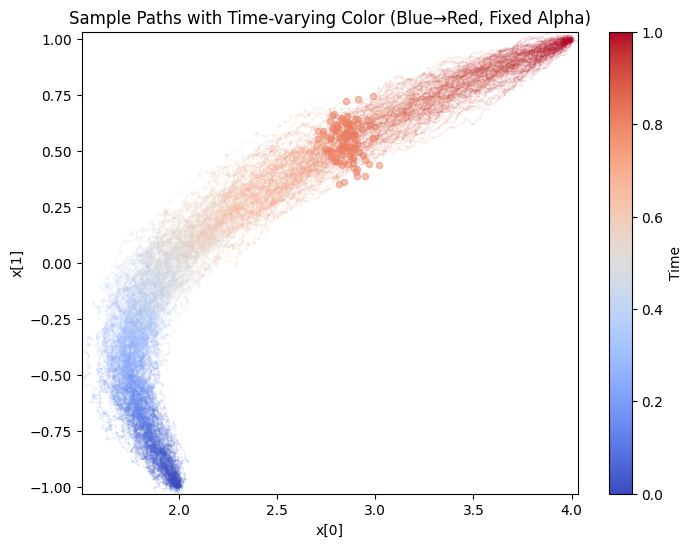

In [163]:
fig, ax = plot_trajectory(xt, t)
plot_samples(x_marginal, t=t_marginal, ax=ax);

# Optimal Transport Cost

In [164]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

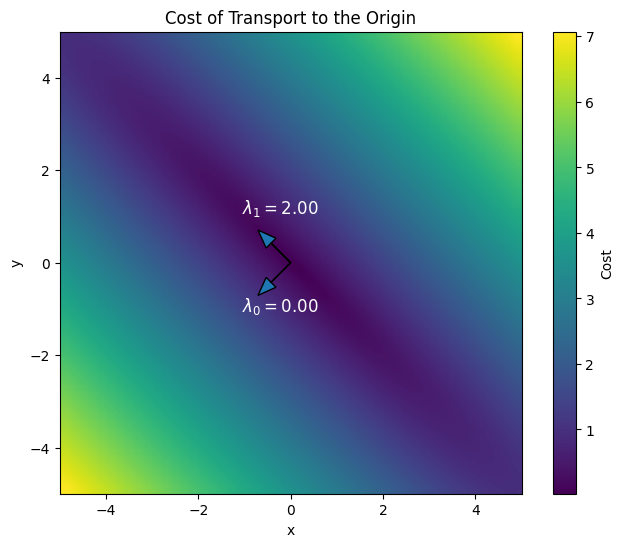

In [165]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

# Data
x1 = torch.tensor([[0.0, 0.0]])

x0_min, x0_max, n_grid = -5.0, 5.0, 50
x01 = torch.linspace(x0_min, x0_max, n_grid)
x02 = torch.linspace(x0_min, x0_max, n_grid)
x01g, x02g = torch.meshgrid(x01, x02, indexing='xy')
grid_shape = x01g.shape
x0 = torch.stack([x01g, x02g], dim=-1).reshape(-1, 2)

x1, x0 = frame.transform(x1, x0)

# SDE and solvers
c = 1.0
sigma = 0.0
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)
ot_solver = OTSolver(sde=sde)
costs = ot_solver.cost(x0, x1).reshape(grid_shape)

x1, x0 = frame.inverse_transform(x1, x0)

# Plot the cost as a heatmap and x1 point
plt.figure(figsize=(8, 6))
ax = plt.gca()
im = ax.imshow(costs, extent=[x0_min, x0_max, x0_min, x0_max], cmap='viridis', origin='lower', interpolation='bessel')
plt.colorbar(im, ax=ax, label='Cost')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Cost of Transport to the Origin')

# Plot eigenvectors as arrows with length proportional to their eigenvalues, centered at the origin
eigenvectors = frame.U  # shape: (n, n)
eigenvalues = frame.D  # shape: (n, n), diagonal matrix of eigenvalues
label_offset = 1.5

for i, (eigenvector, eigenvalue) in enumerate(zip(eigenvectors, eigenvalues)):
    arrow = x1[0]
    eigenvalue = eigenvalue.item()
    ax.arrow(arrow[0], arrow[1], eigenvector[0], eigenvector[1], head_width=0.3, head_length=0.4, length_includes_head=True, label=f"eig {i}: {eigenvalue:.2f}")
    ax.text((arrow[0] + eigenvector[0]) * label_offset, (arrow[1] + eigenvector[1]) * label_offset, f"$\\lambda_{i}={eigenvalue:.2f}$", fontsize=12, color='white')

plt.show()

# Optimal transfer plan and the induced linear flow

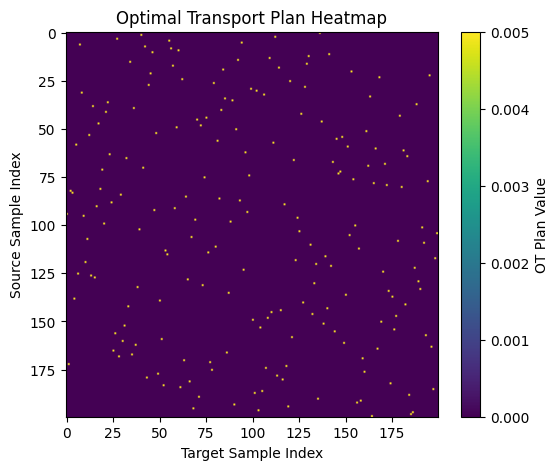

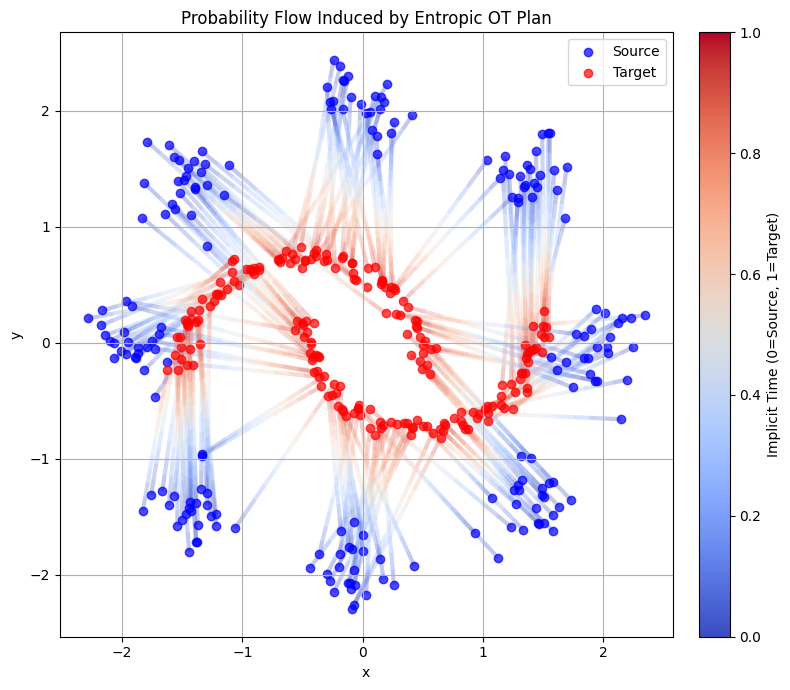

In [167]:
n = 200
x0 = EightGaussians().sample((n,))
x1 = Moons().sample((n,))

x0, x1 = frame.transform(x0, x1)
ot_plan = ot_solver.solve(x0, x1)
x0, x1 = frame.inverse_transform(x0, x1)


plt.figure(figsize=(6, 5))
plt.imshow(ot_plan.cpu(), aspect='auto', cmap='viridis')
plt.colorbar(label='OT Plan Value')
plt.title('Optimal Transport Plan Heatmap')
plt.xlabel('Target Sample Index')
plt.ylabel('Source Sample Index')
plt.show()



# Ensure x0, x1, and ot_plan are on CPU and convert to numpy arrays
x0_np = x0.cpu().numpy() if hasattr(x0, "cpu") else x0.numpy()
x1_np = x1.cpu().numpy() if hasattr(x1, "cpu") else x1.numpy()
ot_plan_np = ot_plan.cpu().numpy() if hasattr(ot_plan, "cpu") else ot_plan.numpy()

# (Assume x0_np, x1_np, ot_plan_np are already CPU NumPy arrays.)
n = x0_np.shape[0]

plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.scatter(x0_np[:, 0], x0_np[:, 1],
           color='blue', label='Source', alpha=0.7)
ax.scatter(x1_np[:, 0], x1_np[:, 1],
           color='red',  label='Target', alpha=0.7)

# parameters
max_plan = ot_plan_np.max()
threshold = 0.01 * max_plan

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=1)

segments = []
colors = []
widths = []

# how many sub‐segments per arrow
n_sub = 10

for i in range(n):
    for j in range(n):
        w = ot_plan_np[i, j]
        if w <= threshold:
            continue

        start = x0_np[i]
        end = x1_np[j]
        # generate equally‐spaced points along the line
        pts = np.linspace(start, end, n_sub + 1)

        # line thickness & overall alpha from flow magnitude
        flow = w / max_plan
        lw = 0.5 + 2.5 * flow
        alpha = flow * 0.3

        # build each tiny segment
        for k in range(n_sub):
            seg_t = [pts[k], pts[k + 1]]
            t = k / n_sub  # 0 at source, 1 at target
            # pick color from cmap and inject our α
            r, g, b, _ = cmap(norm(t))
            colors.append((r, g, b, alpha))
            widths.append(lw)
            segments.append(seg_t)

# assemble the LineCollection
lc = LineCollection(segments,
                    colors=colors,
                    linewidths=widths,
                    zorder=0)
ax.add_collection(lc)

# add colorbar for “time” scale
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(0, 1, 100))   # dummy array
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Implicit Time (0=Source, 1=Target)')

ax.set(title='Probability Flow Induced by Entropic OT Plan',
       xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Synthetic Experiments

## Simple 2d example

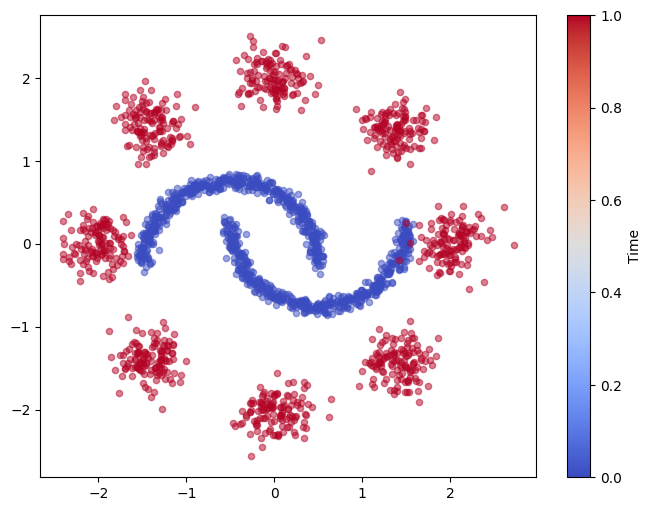

In [21]:
n = 1000
x0 = Moons().sample((n,))
x1 = EightGaussians().sample((n,))
fig, ax = plot_samples(x0, t=0.0, add_colorbar=True)
plot_samples(x1, t=1.0, ax=ax);

In [151]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

# SDE and Solvers 
sigma = 0.0
c = 2.0
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)
ot_solver = OTSolver(sde=sde, epsilon=0.0)

# dataset
x0_distribution = EightGaussians()
x1_distribution = Moons() 
dataset = MatchingDistributionDataset(
    x0_distribution, 
    x1_distribution, 
)

batch_size = 512
num_batches = 50 * 512 // batch_size
train_data_loader = MatchingDataLoader(
    dataset=dataset, 
    batch_sampler=OTBatchSampler(
        dataset=dataset, 
        ot_solver=ot_solver, 
        batch_size=batch_size, 
        num_batches=num_batches,
        batchwise_ot=False, 
    ),
)
eval_data_loader = MatchingDataLoader(
    dataset=dataset, 
    batch_sampler=OTBatchSampler(
        dataset=dataset, 
        ot_solver=ot_solver, 
        batch_size=512, 
        num_batches=1,
        batchwise_ot=False, 
    ),
)

# model and training 
model = ResidualNN(data_dim=2)

num_epochs = 1000 // num_batches * 5
history = fit(
    sde=sde, 
    model=model, 
    train_data_loader=train_data_loader, 
    eval_data_loader=eval_data_loader,
    num_epochs=num_epochs,

)
plot_history(history)

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Sample Paths with Time-varying Color (Blue→Red, Fixed Alpha)'}, xlabel='x[0]', ylabel='x[1]'>)

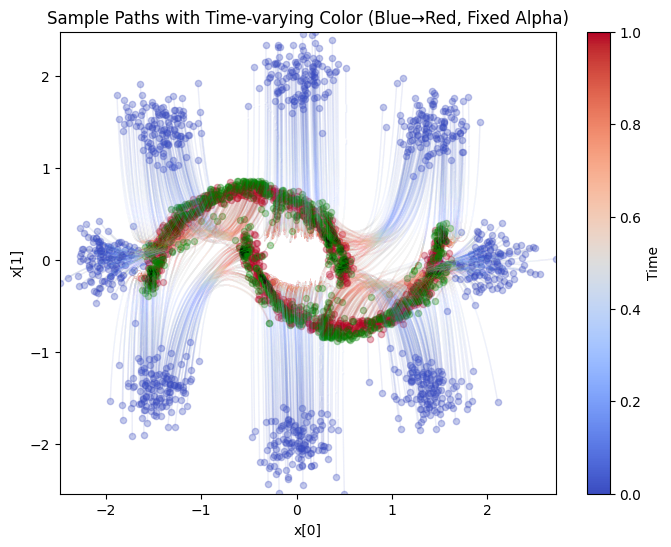

In [152]:
with torch.inference_mode():
    control = ModelControl(model)
    sde_solver = make_sde_solver(sde)
    n_test = 1024
    x0, x1 = dataset.sample((n_test,))
    xt, t = sde_solver.sample_path(x0, control=control)
    x0, xt, x1 = dataset.frame.inverse_transform(x0, xt, x1)


fig, ax = plot_trajectory(xt, t)
plot_samples(x0, t=0.0, ax=ax)
plot_samples(x1, t=1.0, ax=ax)
plot_samples(xt[:, -1], color='green', label='predicted', ax=ax)

# Brain Connectome Experiment

In [ ]:
# settings 
c = 2.0
sigma = 0.0
normalize_variance = False 
batch_size = 512 
num_batches = 20 * 512 // batch_size 
num_epochs = 20000 // num_batches
batchwise_ot = False

# Data
L, x0, x1, x0_train, x0_test, x1_train, x1_test = as_tensors(*load_brain_data())

# Frame, SDE, and solvers 
frame = SpectralFrame(L)
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)

# Dataloaders
train_dataset = MatchingTensorDataset(
    x0=x0_train, 
    x1=x1_train, 
    frame=frame,
)
eval_dataset = MatchingTensorDataset(
    x0=x0_eval, 
    x1=x1_eval, 
    frame=frame,
)
train_data_loader = MatchingDataLoader(
    dataset=dataset, 

)

# Model 
model = ResidualNN(data_dim=x0.shape[-1])

batch_size = 64
num_batches = 20 * 512 // batch_size
num_epochs = 20000 // num_batches 

history = fit(
    sde=sde, 
    model=model, 
    train_data_loader=train_data_loader, 
    eval_data_loader=eval_data_loader, 
    num_epochs=num_epochs,
)

training_losses = train(
    sde=sde, 
    ot_solver=ot_solver, 
    model=model, 
    dataset=dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    num_batches=num_batches, 
    lr=lr, 
    batchwise_ot=batchwise_ot,
)
px.line(training_losses)

Epochs:   0%|          | 0/125 [00:00<?, ?it/s]

: 

In [ ]:
sde_solver = EulerMaruyamaSolver(sde=sde, n=num_timesteps)
with torch.no_grad():
    x0_test_pred = sde_solver.sample_from_terminal(x0=x0_test, control=ModelControl(model))
    test_w1 = wasserstein_distance(x0_test_pred, x1_test, p=1)
    test_w2 = wasserstein_distance(x0_test_pred, x1_test, p=2)

print(f"Wasserstein-1 distance: {test_w1:.4f}")
print(f"Wasserstein-2 distance: {test_w2:.4f}")

plot_brain_signal_2d(x0_test[0]);
plot_brain_signal_2d(x0_test_pred[0]);
plot_brain_signal_2d(x1_test[0]);

Wasserstein-1 distance: 21.9974
Wasserstein-2 distance: 15.6121
